
## Install and Import Modules
#### Install 
Add more if needed. I have provided some installation commands but you may need more if you do not have them installed yet.

In [ ]:
%%capture
# %%capture is used to ignore output when content is boring.
# This is how you install modules from jupyter notebook instead of terminal. 
# Install the one you need or comment them out 
!pip3 install -U imageio-ffmpeg             #It contains VideoFileClip module needed in the next cell. 
!pip3 install moviepy
!pip3 install opencv-contrib-python==4.1.0  #It contains opencv module from https://www.pyimagesearch.com/2018/09/19/pip-install-opencv/
!pip3 install ImageMagick

#### Import
if errors then you may need to go back and install it first. <b>(Restarting Kernel might be necessary too)</b>

In [24]:
# import the necessary packages
import numpy as np
import argparse
import cv2
import os
import random
from moviepy.editor import VideoFileClip,VideoClip,ImageSequenceClip,concatenate_videoclips,TextClip
from moviepy.video import fx
# from moviepy.editor import *
# import moviepy.video.fx.all as vfx
from IPython.display import HTML, YouTubeVideo, display
import matplotlib.pyplot as plt
import shutil
%matplotlib inline

In [2]:
cv2.__version__    # Make sure version above 3.4.3 

'4.1.1'

---
## Watch Input <font color="violet"> Video </font>

Run the sample video I have provided first along with the whole tutorial, then

Try your own video:
- Place your video in the `Input_Video` folder
- Change <b>ONLY</b> the `video_name` in the cell below. 

In [25]:
video_name = "sample.mp4"
input_video_path = os.path.join("Input_Video", video_name)

#Erase this!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
video_name_part = video_name.split(".")    # sample & mp4 has been split
dest_path = os.path.join("Output_Video", video_name_part[0] + "_rotated." + video_name_part[1])
input_video_path = dest_path

# Watch Video
display(HTML("""
            <video width="960" height="540" controls>
              <source src="{0}">
            </video>
            """.format(input_video_path)))

---
## Needs Rotation?
I recorded my video with my phone in horizontal position. So I need to rotate it. Run the cells below if you also need rotation. Otherwise skip this section and go to next section: `Enumerate Frames of Video`

In [ ]:
def rotateImage(image, angle):
    """"
    Performs a counter clockwise rotation of the angle specified. Set Angle to 90 to rotate left or -90 for right  
    """

    (h, w) = image.shape[:2]        # get image height, width
    cx, cy = int(w/2), int(h/2)     # calculate the center of the original image    

    # Translate image center to the right before rotation
    tx = cy-cx     #translate in x
    ty = 0         #translate in y
    M  = np.float32([[1,0,tx],[0,1,ty]])
    image = cv2.warpAffine(image, M, (h,h))       # make square image (hxh)

    # Perform the counter clockwise rotation holding at the center
    center = (cy, cy)               # calculate new center of square image
    scale  = 1.0                    # keep same dimension in image
    M = cv2.getRotationMatrix2D(center, angle, scale)
    image = cv2.warpAffine(image, M, (h, h))

    # Translate image center to the top and crop bottom
    tx = 0          #translate in x
    ty = cx-cy      #translate in y
    M  = np.float32([[1,0,tx],[0,1,ty]])
    image = cv2.warpAffine(image, M, (h,w))       # this crops bottom as well

    return image

Let's implement it on the first frame of the video to make sure everything looks okay. Set `angle` to 90 to rotate left or -90 for right

In [ ]:
# Load video and Read frame
cap = cv2.VideoCapture(input_video_path)
cap.set(cv2.CAP_PROP_POS_FRAMES, 0) #First frame
_, frame = cap.read() 

# Rotate to left
angle = 90
frame_rotated = rotateImage(frame , angle)

# Display
frame = cv2.cvtColor(frame,cv2.COLOR_BGR2RGB)
frame_rotated = cv2.cvtColor(frame_rotated,cv2.COLOR_BGR2RGB)

plt.figure(figsize=(11, 5))   #width, height in inches
plt.subplot(1,2,1)
plt.title("Original")
plt.imshow(frame)

plt.subplot(1,2,2)
plt.title("Rotated")
plt.imshow(frame_rotated)

It works! So let's implemented in the whole video and place it in the `Output_Video` folder which we will create. Again set `angle` to 90 to rotate left or -90 for right

In [ ]:
# Create folder to place output videos at same level directory as input folder
try:
    os.mkdir("Output_Video")
except FileExistsError:
    print ("Output Folder is ready already")
    
# Rotate video
angle = 90
clip  = VideoFileClip(input_video_path)
video_clip = clip.fl_image(lambda image: rotateImage(image, angle))

# Save rotated video 
video_name_part = video_name.split(".")    # sample & mp4 has been split
dest_path = os.path.join("Output_Video", video_name_part[0] + "_rotated." + video_name_part[1])
%time video_clip.write_videofile(dest_path, audio=False)

Let's watch it now! And reassign the input video path to our new rotated video!

In [ ]:
# Reassign Input path to rotated video
input_video_path = dest_path

# Watch Video                                  
HTML("""
    <video width="960" height="540" controls>
      <source src="{0}">
    </video>
    """.format(dest_path)) 

---
## Enumerate Frames of Video
We need to enumerate the frames of our video to know what frames will be with the "lights OFF". Run the cells below to know which frame intervals will remain in the "dark". 

<b>Tips and Tricks:</b> Define a class to keep track of data from previous frames. This will be useful for running our VideoFileClip object later

In [ ]:
class VideoTracker():
    def __init__(self):
        self.current_frame = 0 
    
    def plusOneFrame(self):
        self.current_frame = self.current_frame +1
        
        
videoInfo = VideoTracker()

In [ ]:
def addFrameNumber(image, frame_count, font_scale, color, thickness):
    """"
    Add frame number to an image.  
    """
        
    # Unpack and Define previously known data from video
    frame_num   = videoInfo.current_frame
    
    # Add Number
    h,w = image.shape[:2]
    box_startX, box_startY, box_endX, box_endY = 0, 0, int(0.5*w), int(0.2*h) # Box vertices follows golden ratio 
    image[box_startY: box_endY, box_startX:box_endX] = 0                      # Black rectangle in left corner 
    text = "Frame: "+ str(frame_num) + "/" + str(frame_count)
    text_startX, text_startY = 0, box_endY- int(box_endY*0.4)
    cv2.putText(image, text, (text_startX, text_startY),cv2.FONT_HERSHEY_SIMPLEX, font_scale, color, thickness)
    
    # Update new data for next frame in video 
    videoInfo.plusOneFrame()
    
    return image

Let's first enumerate a random frame from our video to make sure everything looks ok. Set `font_scale`, `color`, and `thickness` to your taste to suit your video.

In [ ]:
# Load video
cap = cv2.VideoCapture(input_video_path)

# Get General Info
fps         = cap.get(cv2.CAP_PROP_FPS)      # OpenCV2 version 2 used "CV_CAP_PROP_FPS"
frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
duration    = int(frame_count/fps)
width       = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))  # float
height      = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)) # float

# Read frame
videoInfo.current_frame = random.randint(0,frame_count-1)
cap.set(cv2.CAP_PROP_POS_FRAMES, videoInfo.current_frame)
_,frame=cap.read()

# Add frame number
font_scale, color, thickness= 2.5, (0, 255, 0), 10
frame = addFrameNumber(frame, frame_count, font_scale, color, thickness)

# Display
print('Frames Per Sec FPS = ' + str(fps))
print('Number of Frames   = ' + str(frame_count))
print('Duration [Sec]     = ' + str(duration))
minutes = int(duration/60)
seconds = duration%60
print('Duration [Min:Sec] = ' + str(minutes) + ':' + str(seconds))
frame = cv2.cvtColor(frame,cv2.COLOR_BGR2RGB)
plt.imshow(frame)
plt.show()

It works! So let's implement it in the whole video and place it in the Output_Video folder which we will create. <b>This may take a while...</b> 

In [ ]:
%%capture
# Create folder to place output videos at same level directory as input folder
try:
    os.mkdir("Output_Video")
except FileExistsError:
    print ("Output Folder is ready already")

# Add Frame Numbers to Video
font_scale, color, thickness = 2.5, (0, 255, 0), 10
videoInfo = VideoTracker()           # reset to begining
clip  = VideoFileClip(input_video_path)
video_clip = clip.fl_image(lambda image: addFrameNumber(image, frame_count, font_scale, color, thickness))

# Save Enumerated video 
video_name_part = video_name.split(".")    # sample & mp4 has been split
dest_path = os.path.join("Output_Video", video_name_part[0] + "_enumerated." + video_name_part[1])
%time video_clip.write_videofile(dest_path, audio=False)

Let's watch it now! Take note of the frame intervals you want to turn OFF the lights.

In [ ]:
# Watch Video 
dest_path = os.path.join("Output_Video", video_name_part[0] + "_enumerated." + video_name_part[1])
HTML("""
    <video width="960" height="540" controls>
      <source src="{0}">
    </video>
    """.format(dest_path)) 

---
## HED Image Processing: "Turn OFF The Lights":

From the previous video we know now that frame intervals [93,184] , [465,1458], and [1588,1662] must be in the "dark." Let's explore on a random frame from our video our HED image processing option first.

For that, a neural network for edge detection called Hollistically-Nested Edge Detector (HED) will be used. This can be implemented with GPU but for simplicity we will use the OpenCV approach which uses CPU only. For more, check my list of edge detection techniques in my repo [EdgeDetection-and-ColorSpaces](https://github.com/laygond/EdgeDetection-and-ColorSpaces.git).

Start by loading Model and adding extra layer to model

In [4]:
# Create new Layer to add to current net
class CropLayer(object):
    def __init__(self, params, blobs):
        # initialize our starting and ending (x, y)-coordinates of
        # the crop
        self.startX = 0
        self.startY = 0
        self.endX = 0
        self.endY = 0

    def getMemoryShapes(self, inputs):
        # the crop layer will receive two inputs -- we need to crop
        # the first input blob to match the shape of the second one,
        # keeping the batch size and number of channels
        (inputShape, targetShape) = (inputs[0], inputs[1])
        (batchSize, numChannels) = (inputShape[0], inputShape[1])
        (H, W) = (targetShape[2], targetShape[3])

        # compute the starting and ending crop coordinates
        self.startX = int((inputShape[3] - targetShape[3]) / 2)
        self.startY = int((inputShape[2] - targetShape[2]) / 2)
        self.endX = self.startX + W
        self.endY = self.startY + H

        # return the shape of the volume (we'll perform the actual
        # crop during the forward pass
        return [[batchSize, numChannels, H, W]]

    def forward(self, inputs):
        # use the derived (x, y)-coordinates to perform the crop
        return [inputs[0][:, :, self.startY:self.endY,
                self.startX:self.endX]]


In [5]:
# load model
protoPath = os.path.join("hed_model","deploy.prototxt")
modelPath = os.path.join("hed_model","hed_pretrained_bsds.caffemodel")
net = cv2.dnn.readNetFromCaffe(protoPath, modelPath)

# register our new layer with the model
cv2.dnn_registerLayer("Crop", CropLayer)

Define our pipeline workflow through which each image will be passed in

In [14]:
def hed_pipeline(image):
    # Preprocess image
    (height, width) = image.shape[:2]
    blob = cv2.dnn.blobFromImage(image, scalefactor=1.0, size=(width, height),
                                mean=(104.00698793, 116.66876762, 122.67891434),
                                swapRB=False, crop=False)

    # Run Model: Perform a forward pass of blob image
    net.setInput(blob)
    hed = net.forward()
    hed = cv2.resize(hed[0, 0], (width, height))
    hed = (255 * hed).astype("uint8")
    hed = np.dstack((hed,hed,hed))
    
    return hed

Run image through our model pipeline.

(1080, 1920, 3)
(1080, 1920, 3)


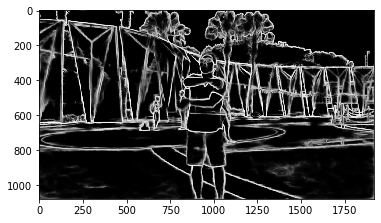

In [15]:
# Load video
cap = cv2.VideoCapture(input_video_path)
frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

# Read frame
frame_num = random.randint(0,frame_count-1)
cap.set(cv2.CAP_PROP_POS_FRAMES, frame_num)
_,frame=cap.read()

# Apply HED to frame
frame = hed_pipeline(frame)

# Display
frame = cv2.cvtColor(frame,cv2.COLOR_BGR2RGB)
plt.imshow(frame)
plt.show()

### Split & Concatenate Small Clips
Frame intervals [93,184] , [465,1458], and [1588,1662] must be in the "dark."

In [20]:
# Create folder to place output videos at same level directory as input folder
try:
    os.mkdir("Output_Video")
except FileExistsError:
    print ("Output Folder is ready already")

    
# Transform frame numbers into seconds for 'Video File Clip'
clip   = VideoFileClip(input_video_path)
dark_time  = np.floor(np.array([[93,184] , [465,1458], [1588,1662]]) / clip.fps * 10)/10  # one decimal place only 
light_time = np.reshape(np.hstack((np.array([0.0]),dark_time.flatten()[:-1] )), (3, 2))   # append zero in front, delete last time value, reshape
print("\n Dark Time Intervals \n", dark_time,"\n\n Light Time Intervals \n", light_time, "\n")


# Split Video into dark and light clips
light_clips = []
for interval in light_time:
    start, end = interval
    light_clips.append(clip.subclip(start,end))

dark_clips = []
for interval in dark_time:
    start, end = interval
    sub_clip   = clip.subclip(start,end)
    dark_clip  = sub_clip.fl_image(hed_pipeline)
    dark_clips.append(dark_clip)

    
# Concatenate Clips
video_clips = [pair_clips for pair_clips in zip(light_clips, dark_clips)] # list of clip tuples
video_clips = [element for tupl in video_clips for element in tupl]       # flatten tuples (into one dimensional list)
video_clip  = concatenate_videoclips(video_clips)
    
    
# Save video 
video_name_part = video_name.split(".")    # sample & mp4 has been split
dest_path = os.path.join("Output_Video", video_name_part[0] + "_output1." + video_name_part[1])
%time video_clip.write_videofile(dest_path, audio=False, fps=30)


Output Folder is ready already

 Dark Time Intervals 
 [[ 3.1  6.1]
 [15.5 48.6]
 [52.9 55.4]] 

 Light Time Intervals 
 [[ 0.   3.1]
 [ 6.1 15.5]
 [48.6 52.9]] 

Moviepy - Building video Output_Video\sample_output.mp4.
Moviepy - Writing video Output_Video\sample_output.mp4



Moviepy - Done !
Moviepy - video ready Output_Video\sample_output.mp4
Wall time: 3h 57min 43s


Let's watch it now!

In [26]:
# Watch Video 
dest_path = os.path.join("Output_Video", video_name_part[0] + "_output." + video_name_part[1])
HTML("""
    <video width="960" height="540" controls>
      <source src="{0}">
    </video>
    """.format(dest_path)) 

---
# Tracking Balls
Determine on one frame the region of interest you would like to track. I want to start tracking from frame 1459 until frame 1587. Since the object we want to track is more visible in frame 1520, we will track it from there forwards and backwards, i.e., [1520 ,1459] and from [1520, 1587]

Let's see frame 1520 (In your case, choose the frame that you consider the target object more visible)

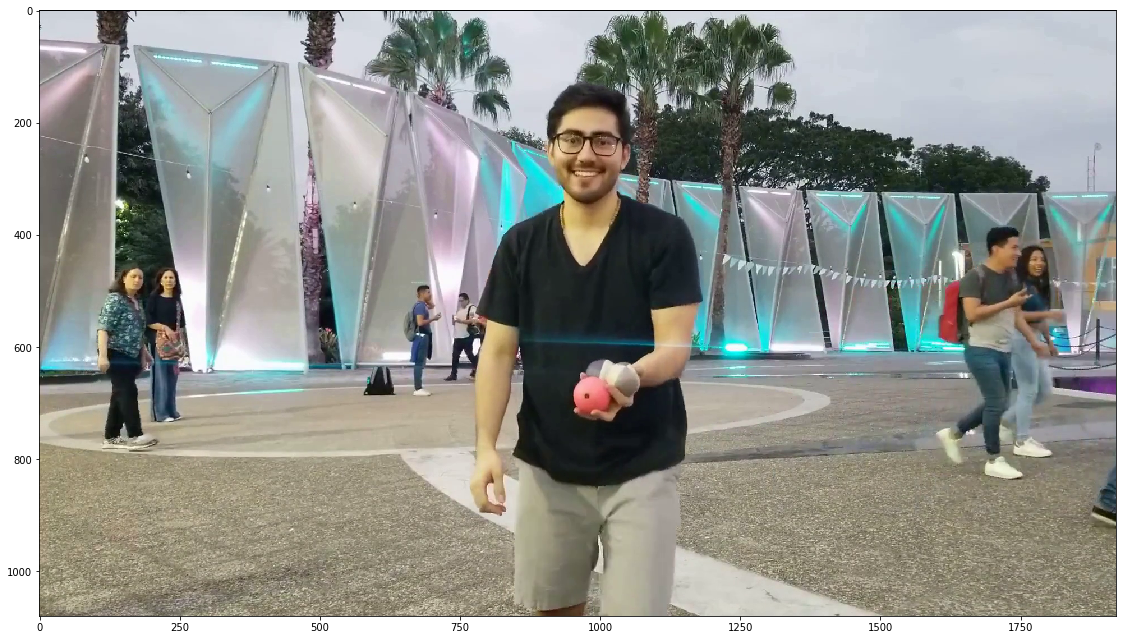

In [27]:
# Output from HED
video_path = os.path.join("Output_Video", video_name_part[0] + "_output." + video_name_part[1])

# Load video
cap = cv2.VideoCapture(video_path)
frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

# Read frame
frame_num = 1520
cap.set(cv2.CAP_PROP_POS_FRAMES, frame_num)
_,frame=cap.read()

# Display
f, ax = plt.subplots(1, 1, figsize=(24, 9))  # width and heights in inches
f.tight_layout()
ax.imshow(cv2.cvtColor(frame,cv2.COLOR_BGR2RGB))

Determine region of interest using your mouse (you can set this manually if you do not have this feature)

In [ ]:
box = cv2.selectROI("Frame", frame, fromCenter=False,showCrosshair=True)


Draw bounding box on image to make sure the region you want to track is the correct one

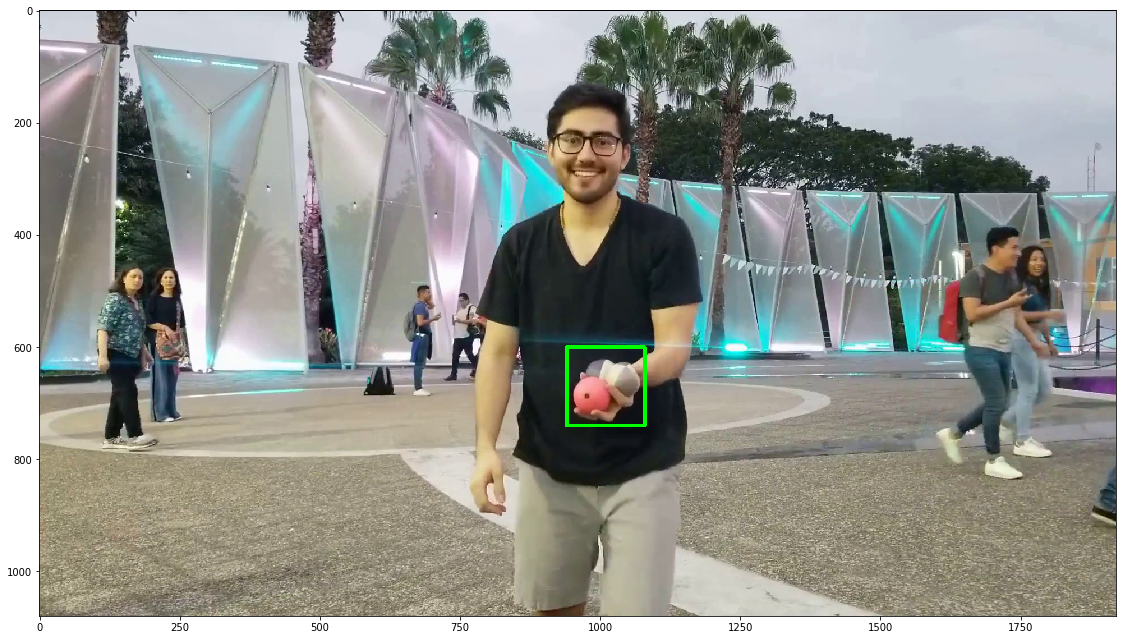

In [28]:
box = (940,600,140,140) # Manual method if above fails 
(x,y,w,h) = box        # x,y are the top left corner of box; w,h are the width and height of box

color, thickness = (0,255,0), 5
frame_rect = cv2.rectangle(frame, (x,y), (x+w,y+h), color, thickness) 

# Display
f, ax = plt.subplots(1, 1, figsize=(24, 9))  # width and heights in inches
f.tight_layout()
ax.imshow(cv2.cvtColor(frame_rect,cv2.COLOR_BGR2RGB))

Let's implement helper functions that will allow us to add our tracker just to the portion of the video we want. 

In [29]:
def visualize_track_on_image(image):
    """
    In an image it updates the tracker to later add visualization cues to the object being tracked.
    It draws bounding box coordinates around the target and also applies the HED pipeline to 'hide' the target.
    """
    # object that is being tracked
    (success, boxes) = trackers.update(image)

    # loop over the bounding boxes and draw the visual cues on the image
    for box in boxes:
        (x, y, w, h) = [int(v) for v in box]
        color, thickness = (0,255,0), 5
        cv2.rectangle(image, (x, y), (x + w, y + h), color, thickness)
        
    return image


def add_tracker_to_video(clip, start_time, end_time):
    """
    Add tracker to a video clip object in the time interval specified. Time should be in seconds.
    If start_time is greater than end_time the tracker is applied backwards in time.
    It returns just that clip interval.    
    """
    # Reverse Video Flag
    REVERSE_VIDEO = False
    if  start_time > end_time:
        start_time, end_time =  end_time, start_time
        REVERSE_VIDEO = True
        print("[INFO] REVERSE_VIDEO ON...")
        
    # Track object
    track_clip   = clip.subclip(start_time, end_time)
    if REVERSE_VIDEO:
        track_clip = track_clip.fx(fx.all.time_mirror)   # time_mirror makes the clip play backwards
        track_clip = track_clip.fl_image(track_on_image)   
        track_clip = track_clip.fx(fx.all.time_mirror)   # set video back to normal
    else:
        track_clip = track_clip.fl_image(track_on_image)

    return track_clip

Here we define the tracker and apply it to our video. Recall that the object we want to track is more visible in frame 1520, we will track it from there forwards and backwards, i.e., [1520 ,1459] and from [1520, 1587]. Finally, we will concatenate all video clips.

In [ ]:
%%capture
# Make clip of Video
video_path = os.path.join("Output_Video", video_name_part[0] + "_output." + video_name_part[1])
clip  = VideoFileClip(video_path)

# initialize a dictionary of OpenCV object trackers
OPENCV_OBJECT_TRACKERS = {
    "csrt": cv2.TrackerCSRT_create,
    "kcf": cv2.TrackerKCF_create,
    "boosting": cv2.TrackerBoosting_create,
    "mil": cv2.TrackerMIL_create,
    "tld": cv2.TrackerTLD_create,
    "medianflow": cv2.TrackerMedianFlow_create,
    "mosse": cv2.TrackerMOSSE_create
}

# initialize OpenCV's special multi-object tracker
trackers = cv2.MultiTracker_create()

# Track backward part
tracker = OPENCV_OBJECT_TRACKERS['csrt']()
trackers.add(tracker, frame, box)
start_time, end_time = int(1520*10/clip.fps)/10.0, int(1459*10/clip.fps)/10.0    # one decimal place
track_clip_1 = add_tracker_to_video(clip, start_time, end_time)

# Track forward part
# tracker = OPENCV_OBJECT_TRACKERS['csrt']()
# trackers.add(tracker, frame, box)
start_time, end_time = int(1520*10/clip.fps)/10.0, int(1587*10/clip.fps)/10.0    # one decimal place
track_clip_2 = add_tracker_to_video(clip, start_time, end_time)

# Remaining video clips
start_time, end_time = 0, int(1459*10/clip.fps)/10.0                             # one decimal place
before_clip = clip.subclip(start_time, end_time)

start_time, end_time = int(1587*10/clip.fps)/10.0, clip.duration                 # one decimal place
after_clip  = clip.subclip(start_time, end_time)


# Concatenate clips
video_clips = [before_clip, track_clip_1, track_clip_2, after_clip]
video_clip  = concatenate_videoclips(video_clips)

# Save Video 
video_name_part = video_name.split(".")    # sample & mp4 has been split
dest_path = os.path.join("Output_Video", video_name_part[0] + "_output__tracker." + video_name_part[1])
%time video_clip.write_videofile(dest_path, audio=False)

Let's watch it!

In [ ]:
# Watch Video 
dest_path = os.path.join("Output_Video", video_name_part[0] + "_output__tracker." + video_name_part[1])
HTML("""
    <video width="960" height="540" controls>
      <source src="{0}">
    </video>
    """.format(dest_path)) 

---
## Add Borders

Modify the `add_border` function to your taste. I have decided to increase the top and bottom border to give it a movie style to my video clip. 

In [ ]:
def add_border(image): 
    # Add Border
    (height, width) = image.shape[:2]
    color = [0,0,0]     # Black Borders
    image = cv2.copyMakeBorder(image, top=int(0.15*height), bottom=int(0.15*height), left=0, right=0, borderType=cv2.BORDER_CONSTANT, value=color)
    return image

First let's try it in one image

In [ ]:
# Output from HED
video_path = os.path.join("Output_Video", video_name_part[0] + "_output." + video_name_part[1])

# Load video
cap = cv2.VideoCapture(video_path)
frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

# Read frame
frame_num = random.randint(0,frame_count-1)
cap.set(cv2.CAP_PROP_POS_FRAMES, frame_num)
_,frame=cap.read()

# Add black border (Movie style) and my Text Watermark
frame = add_border(frame)

# Display
frame = cv2.cvtColor(frame,cv2.COLOR_BGR2RGB)
plt.imshow(frame)
plt.show()

I works! Let's make a video out of it

In [ ]:
%%capture
# Add Border to Video
clip  = VideoFileClip(video_path)
video_clip = clip.fl_image(add_border)

# Save Movie Style Video 
video_name_part = video_name.split(".")    # sample & mp4 has been split
dest_path = os.path.join("Output_Video", video_name_part[0] + "_output__movie_style." + video_name_part[1])
%time video_clip.write_videofile(dest_path, audio=False)

In [ ]:
# Watch Video 
dest_path = os.path.join("Output_Video", video_name_part[0] + "_output__movie_style." + video_name_part[1])
HTML("""
    <video width="960" height="540" controls>
      <source src="{0}">
    </video>
    """.format(dest_path)) 

---
## Add Text
Texts are temporal which means they can stay for a certain amount of time in the video. Let's create such function. But first, let's find the location of where all temporary text will be placed throughout the entire video.

In [ ]:
# Output from HED + Border
video_path = os.path.join("Output_Video", video_name_part[0] + "_output__movie_style." + video_name_part[1])

# Load video
cap = cv2.VideoCapture(video_path)
frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

# Read frame
frame_num = random.randint(0,frame_count-1)
cap.set(cv2.CAP_PROP_POS_FRAMES, frame_num)
_,frame=cap.read()

# Explore the best location, font, color, etc of all your texts.
(height, width) = frame.shape[:2]

text = "Up for the Challenge?!"
text_startX, text_startY = int(width/2- width*0.15), int(0.07*height)
font_scale, color, thickness= 2, (255, 255, 255), 5
cv2.putText(frame, text, (text_startX, text_startY),cv2.FONT_HERSHEY_SIMPLEX, font_scale, color, thickness)

text = "Follow the Pink Ball"
text_startX, text_startY = int(width/2- width*0.15), int(height- 0.05*height)
font_scale, color, thickness= 2, (255, 255, 255), 5
cv2.putText(frame, text, (text_startX, text_startY),cv2.FONT_HERSHEY_SIMPLEX, font_scale, color, thickness)

text = "@caic.espol"
text_startX, text_startY = int(width/2+ width*0.2), int(height- 0.17*height)
font_scale, color, thickness= 1.2, (255, 255, 255), 3
cv2.putText(frame, text, (text_startX, text_startY),cv2.FONT_HERSHEY_SIMPLEX, font_scale, color, thickness)

# Display
frame = cv2.cvtColor(frame,cv2.COLOR_BGR2RGB)
plt.imshow(frame)
plt.show()

In [ ]:
def add_text_to_video(clip, text, start_time, end_time, text_loc, font_scale=1.2, color=(255, 255, 255), thickness=3):
    """
    Add personalized text to a video clip object in the time interval and location specified. Time should be in seconds.
    
    """
    # Split video
    before_clip = clip.subclip(0, start_time)
    text_clip   = clip.subclip(start_time, end_time)
    after_clip  = clip.subclip(end_time, clip.duration) if end_time != clip.duration else clip.subclip(0,0) # Empty clip
        
    # Add text    
    text_clip = text_clip.fl_image(lambda image: cv2.putText(image, text, text_loc, cv2.FONT_HERSHEY_SIMPLEX, font_scale, color, thickness))
    
    # Concatenate video
    video_clips = [before_clip, text_clip, after_clip]
    video_clip  = concatenate_videoclips(video_clips)

    return video_clip

Now that we have our function and know where we want our text let's make our video!

In [ ]:
%%capture
# Add Text to Video
video_path = os.path.join("Output_Video", video_name_part[0] + "_output__movie_style." + video_name_part[1])
clip = VideoFileClip(video_path)

text = "Up for the Challenge?!"
text_loc = (int(width/2- width*0.15), int(0.07*height))
font_scale, color, thickness= 2, (255, 255, 255), 5
start_time, end_time = 0, int(clip.duration/2)
video_clip = add_text_to_video(clip, text, start_time, end_time, text_loc, font_scale, color, thickness)

text = "Follow the Pink Ball"
text_loc = (int(width/2- width*0.15), int(height- 0.05*height))
font_scale, color, thickness= 2, (255, 255, 255), 5    
start_time, end_time = 0, int(clip.duration/2)
video_clip = add_text_to_video(video_clip, text, start_time, end_time, text_loc, font_scale, color, thickness)

text = "@caic.espol"
text_loc = ( int(width/2+ width*0.2), int(height- 0.17*height))
font_scale, color, thickness= 1.2, (255, 255, 255), 3
start_time, end_time = 0, clip.duration
video_clip = add_text_to_video(video_clip, text, start_time, end_time, text_loc, font_scale, color, thickness)
   
# Save Video with text
video_name_part = video_name.split(".")    # sample & mp4 has been split
dest_path = os.path.join("Output_Video", video_name_part[0] + "_output__movie_style__text." + video_name_part[1])
%time video_clip.write_videofile(dest_path, audio=False)

In [ ]:
# Watch Video 
dest_path = os.path.join("Output_Video", video_name_part[0] + "_output__movie_style__text." + video_name_part[1])
HTML("""
    <video width="960" height="540" controls>
      <source src="{0}">
    </video>
    """.format(dest_path)) 

---
## Add Question Game Frame (Add Image to Video)
This section gives the appearance that the video has been paused for several seconds. Let's edit the frame we would like to repeat throughout the video to give the sense it has been frozen. That is frame number 1560 in my case.

In [ ]:
# Output from HED + Border + Text
video_path = os.path.join("Output_Video", video_name_part[0] + "_output__movie_style__text." + video_name_part[1])

# Load video
cap = cv2.VideoCapture(video_path)
frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

# Read frame
frame_num = 1560
cap.set(cv2.CAP_PROP_POS_FRAMES, frame_num)
_,frame=cap.read()

# Explore the best location, font, color, etc of all your texts.
(height, width) = frame.shape[:2]
font_scale, color, thickness= 2, (255, 255, 255), 5

text = "A"
text_startX, text_startY = 910, 800
cv2.putText(frame, text, (text_startX, text_startY),cv2.FONT_HERSHEY_SIMPLEX, font_scale, color, thickness)

text = "B"
text_startX, text_startY = 950, 1000
cv2.putText(frame, text, (text_startX, text_startY),cv2.FONT_HERSHEY_SIMPLEX, font_scale, color, thickness)

text = "C"
text_startX, text_startY = 1150,950
cv2.putText(frame, text, (text_startX, text_startY),cv2.FONT_HERSHEY_SIMPLEX, font_scale, color, thickness)

text = "SHOW ME YOUR POWERS"
text_startX, text_startY = int(width/2- width*0.15), int(0.07*height)
cv2.putText(frame, text, (text_startX, text_startY),cv2.FONT_HERSHEY_SIMPLEX, font_scale, color, thickness)

text = "WHICH ONE IS IT ???"
text_startX, text_startY = int(width/2- width*0.15), int(height- 0.05*height)
cv2.putText(frame, text, (text_startX, text_startY),cv2.FONT_HERSHEY_SIMPLEX, font_scale, color, thickness)


# Display
question_frame = cv2.cvtColor(frame,cv2.COLOR_BGR2RGB)
plt.imshow(question_frame)
plt.show()

Let's create a function that deals with inserting the `question_frame` image into our video.

In [ ]:
def add_image_to_video(clip, image, time, duration):
    """
    Inserts an image (RGB numpy array) into a video clip object at the time specified for the duration given.
    time and duration are in seconds. 
    """
    # Callable function for VideoClip class
    def get_frame(t):
        return image   
    
    # Split video
    before_clip = clip.subclip(0, time)
    extra_clip  = VideoClip(get_frame, duration=duration)
    after_clip  = clip.subclip(time, clip.duration) if time != clip.duration else clip.subclip(0,0) # Empty clip
        
    # Concatenate video
    video_clips = [before_clip, extra_clip, after_clip]
    video_clip  = concatenate_videoclips(video_clips)

    return video_clip

In [ ]:
%%capture
# Add question image into video
clip = VideoFileClip(video_path)
time, duration = frame_num/clip.fps , 4  # seconds 
video_clip = add_image_to_video(clip, question_frame, time ,duration)

# Save Video 
video_name_part = video_name.split(".")    # sample & mp4 has been split
dest_path = os.path.join("Output_Video", video_name_part[0] + "_output__movie_style__text__question." + video_name_part[1])
%time video_clip.write_videofile(dest_path, audio=False, fps=30)

In [ ]:
# Watch Video 
dest_path = os.path.join("Output_Video", video_name_part[0] + "_output__movie_style__text__question." + video_name_part[1])
HTML("""
    <video width="960" height="540" controls>
      <source src="{0}">
    </video>
    """.format(dest_path)) 